# Eruption/deposition age estimation demonstration

This Jupyter notebook demonstrates the eruption (/deposition) age estimation algorithm of [Keller, Schoene, and Samperton (2018)](https://doi.org/10.7185/geochemlet.1826) as implemented in [Chron.jl](https://github.com/brenhinkeller/Chron.jl).

<a href="https://mybinder.org/v2/gh/brenhinkeller/Chron.jl/main?filepath=examples%2FEruptionDepositionAgeDemonstration.ipynb" target="_blank"><img src="https://static.mybinder.org/badge_logo.svg" alt="Launch Binder notebook" align="left"></a> 
<p style="text-indent: 5px">If running this notebook as an online Binder notebook and the webpage times out, click the badge at left to relaunch (refreshing will not work). Note that any changes will be lost!</p>

Hint: `shift`-`enter` to run a single cell, or from the `Cell` menu select `Run All` to run the whole file. Any code from this notebook can be copied and pasted into the Julia REPL or a `.jl` script.
***

## (1) Load required Julia packages

In [1]:
# Load (and install if necessary) the Chron.jl package
using Chron
using Plots

***
## (2a) Test Bayesian eruption age estimation with a synthetic dataset
#### Generate synthetic zircon dataset, drawing from `MeltsVolcanicZirconDistribution`

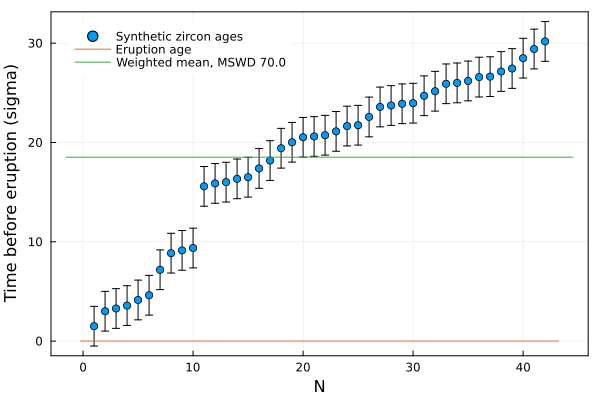

In [2]:
dt_sigma = 30; # Timescale relative to analytical uncertainty
N = 42; # Number of zircons
 
# Draw set of pseudorandom ages from MELTS volcanic zircon distribution, 
# with true minimum == 0 and analytical sigma == 1
ages = draw_from_distribution(MeltsVolcanicZirconDistribution,N).*dt_sigma + randn(N);
uncert = ones(N)

# Calculate the weighted mean age
(wx, wsigma, mswd) = awmean(ages, uncert)

h = plot(framestyle=:box,
    ylabel="Time before eruption (sigma)", 
    xlabel="N", 
    fg_color_legend=:white, 
    legend=:topleft, 
)
plot!(h,1:length(ages),sort(ages),yerror=uncert*2,seriestype=:scatter, label="Synthetic zircon ages")
plot!(h,collect(xlims()), [0,0], label="Eruption age")
plot!(h,collect(xlims()), [wx,wx], label="Weighted mean, MSWD $(round(mswd,sigdigits=2))")

#### Calculate bootstrapped $\ \mathcal{\vec{f}}_{xtal}(t_r)$

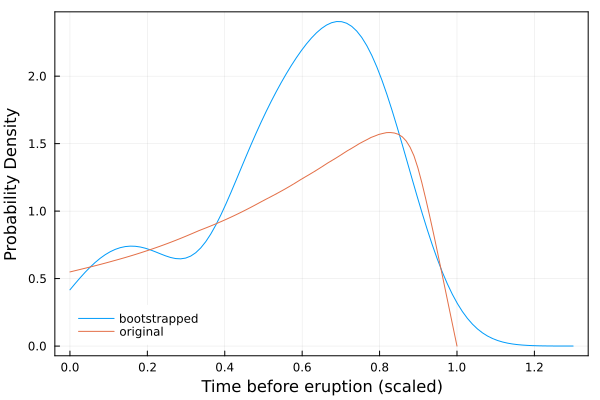

In [3]:
# Bootstrap the crystallization distribution, 
# accounting for any expected analytical "tail" beyond eruption/deposition
dist = BootstrapCrystDistributionKDE(ages, uncert)
dist ./= nanmean(dist) # Normalize

# Plot bootstrapped distribution
plot(range(0,1.3,length=length(dist)),dist, label="bootstrapped", ylabel="Probability Density", xlabel="Time before eruption (scaled)", legend=:bottomleft, fg_color_legend=:white, framestyle=:box)
plot!(range(0,1,length=100),MeltsVolcanicZirconDistribution,label="original")

#### Run MCMC to estimate eruption/deposition age distribution of synthetic dataset


Estimated eruption age of synthetic dataset:
 0.9130201471002158 +/- 2.28596695543814 Ma (2σ)
 (True synthetic age 0 Ma)

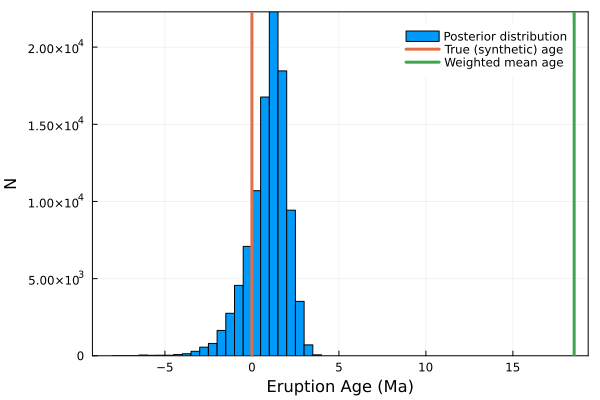

In [4]:
# Configure model
nsteps = 200000; # Length of Markov chain
burnin = 100000; # Number of steps to discard at beginning of Markov chain

# Run MCMC
tminDist = metropolis_min(nsteps,dist,ages,uncert);

# Print results
AgeEst = nanmean(tminDist[burnin:end]);
AgeEst_sigma = nanstd(tminDist[burnin:end]);
print("\nEstimated eruption age of synthetic dataset:\n $AgeEst +/- $(2*AgeEst_sigma) Ma (2σ)\n (True synthetic age 0 Ma)")

# Plot results
h = histogram(tminDist[burnin:end],
    nbins=50,
    label="Posterior distribution",
    xlabel="Eruption Age (Ma)",
    ylabel="N", 
    framestyle=:box
)
plot!(h,[0,0],collect(ylims()),line=(3),label="True (synthetic) age",fg_color_legend=:white)
plot!(h,[wx,wx],collect(ylims()),line=(3),label="Weighted mean age",legend=:topright)
display(h)

sleep(0.5) # (just to make sure this section is finished running)

***
## (2b) Estimate eruption age for real zircon data
The example dataset here is from [Wotzlaw et al., 2013](https://doi.org/10.1130/G34366.1) FCT+MLX
#### Input dataset (Try pasting in your own data here!)

In [5]:
# Age and one-sigma uncertainty.
ages = [28.196, 28.206, 28.215, 28.224, 28.232, 28.241, 28.246, 28.289, 28.308, 28.332, 28.341, 28.359, 28.379, 28.383, 28.395, 28.4, 28.405, 28.413, 28.415, 28.418, 28.42, 28.422, 28.428, 28.452, 28.454, 28.454, 28.458, 28.468, 28.471, 28.475, 28.482, 28.485, 28.502, 28.52, 28.551, 28.561, 28.565, 28.582, 28.584, 28.586, 28.611, 28.638, 28.655]
uncert = [0.019, 0.0155, 0.019, 0.0215, 0.018, 0.023, 0.013, 0.029, 0.0175, 0.0315, 0.0095, 0.0245, 0.0255, 0.0175, 0.0235, 0.014, 0.021, 0.022, 0.0125, 0.0135, 0.016, 0.0195, 0.0175, 0.0125, 0.01, 0.014, 0.015, 0.0205, 0.0155, 0.011, 0.0115, 0.0185, 0.0255, 0.014, 0.0125, 0.013, 0.015, 0.014, 0.012, 0.016, 0.0215, 0.0125, 0.0215]

# Sort by age (just to make rank-order plots prettier)
t = sortperm(ages)
ages = ages[t];
uncert = uncert[t];

#### Calculate bootstrapped $\ \mathcal{\vec{f}}_{xtal}(t_r)$

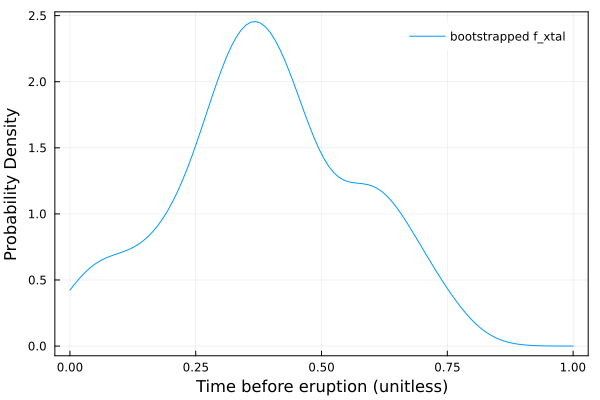

In [6]:
# Bootstrap the crystallization distribution, 
# accounting for any expected analytical "tail" beyond eruption/deposition
BootstrappedDistribution = BootstrapCrystDistributionKDE(ages, uncert)
BootstrappedDistribution ./= nanmean(BootstrappedDistribution) # Normalize

# Plot bootstrapped distribution
plot(range(0,1,length=length(BootstrappedDistribution)),BootstrappedDistribution, 
    label="bootstrapped f_xtal", 
    ylabel="Probability Density", 
    xlabel="Time before eruption (unitless)", 
    fg_color_legend=:white, 
    framestyle=:box
)


#### Run MCMC to estimate eruption age


Estimated eruption age:
 28.184890045741966 +/- 0.03518848913616867 Ma (2σ)


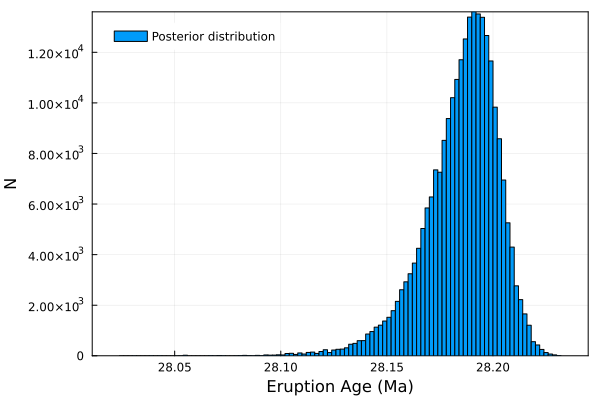

In [7]:
# Configure model
nsteps = 400000; # Length of Markov chain
burnin = 150000; # Number of steps to discard at beginning of Markov chain

# Choose the form of the prior closure/crystallization distribution to use
dist = BootstrappedDistribution
## You might alternatively consider:
# dist = UniformDistribution              # A reasonable default
# dist = MeltsVolcanicZirconDistribution  # A single magmatic pulse, truncated by eruption
# dist = ExponentialDistribution          # Applicable for survivorship processes, potentially including inheritance/dispersion in Ar-Ar dates

# Run MCMC
tminDist = metropolis_min(nsteps,dist,ages,uncert);

# Print results
AgeEst = nanmean(tminDist[burnin:end]);
AgeEst_sigma = nanstd(tminDist[burnin:end]);
print("\nEstimated eruption age:\n $AgeEst +/- $(2*AgeEst_sigma) Ma (2σ)\n")

# Plot results
h = histogram(tminDist[burnin:end],nbins=100,label="Posterior distribution",xlabel="Eruption Age (Ma)",ylabel="N",legend=:topleft,fg_color_legend=:white, framestyle=:box)
# plot!(h,[wx,wx],collect(ylims()),line=(3),label="Weighted mean age",legend=:topleft)
display(h)
sleep(0.5)

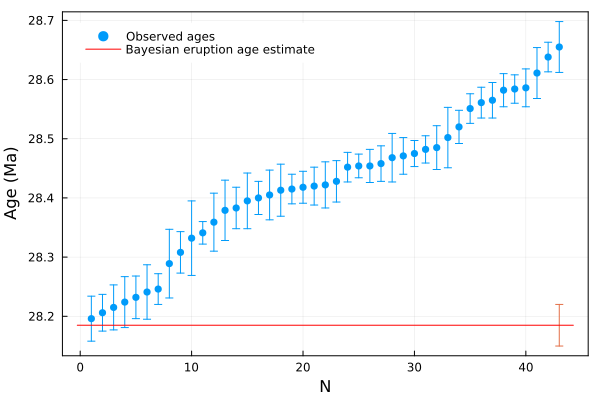

In [8]:
# Plot eruption age estimate relative to rank-order plot of raw zircon ages
h = plot(framestyle=:box,
    ylabel="Age (Ma)", 
    xlabel="N", 
    legend=:topleft, 
    fg_color_legend=:white,
)
plot!(h,1:length(ages),ages,yerror=uncert*2,seriestype=:scatter, markerstrokecolor=:auto, label="Observed ages")
plot!(h,[length(ages)],[AgeEst],yerror=2*AgeEst_sigma, markerstrokecolor=:auto, label="Bayesian eruption age estimate",color=:red)
plot!(h,collect(xlims()),[AgeEst,AgeEst],color=:red, label="")


***